In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/cleaned_dataset.csv")


In [3]:
cols_to_drop = ['cluster_kmeans', 'Number of Records', 'Country']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

In [4]:
df_model = df_clean.drop(columns=['GDP'], errors='ignore')

In [16]:
# Use df_model, which has the columns dropped
num_col = df_model.select_dtypes(include=[np.number]).columns

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model[num_col])

# PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)

print("Number of PCA components:", pca.n_components_)
X = pca_data  # Feature matrix for clustering



Number of PCA components: 13


In [17]:
K_range = range(2, 11)
inertias = []
sil_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))


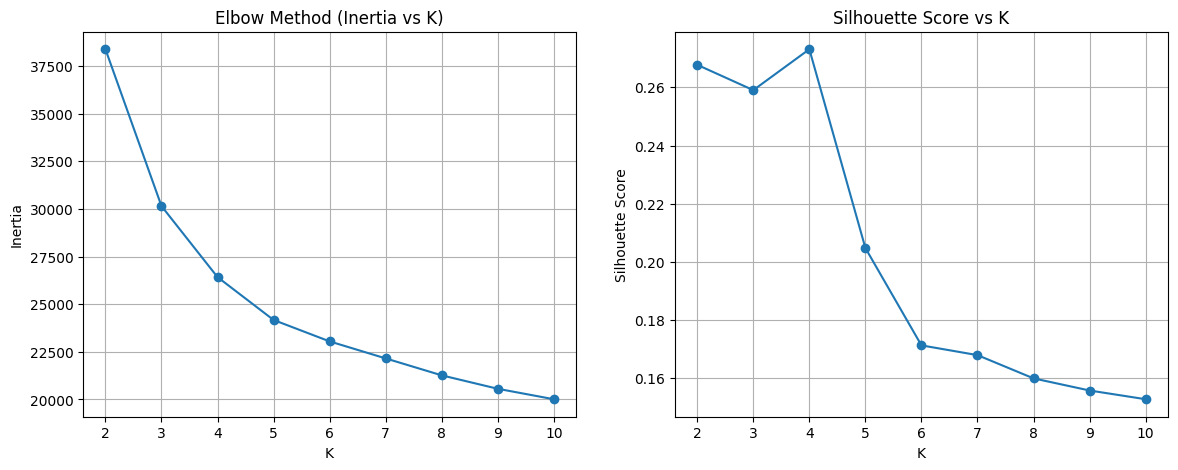

In [18]:
plt.figure(figsize=(14,5))

# Elbow
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid()

# Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()


In [19]:
optimal_K = 3 # chosen from elbow + silhouette

kmeans_final = KMeans(n_clusters=optimal_K, random_state=42)
cluster_labels = kmeans_final.fit_predict(X)

df['cluster_kmeans'] = cluster_labels
df['cluster_kmeans'].value_counts()


,count
cluster_kmeans,
0,1181
2,885
1,638


In [20]:
important_cols = [
    'GDP', 'Log_GDP', 'CO2 Emissions', 'Life Expectancy Female',
    'Internet Usage', 'Mobile Phone Usage',
    'Health Exp % GDP', 'Health Exp/Capita',
    'Tourism Inbound', 'Tourism Outbound',
    'Population Urban', 'Infant Mortality Rate'
]

important_cols = [c for c in important_cols if c in df.columns]

cluster_profile = df.groupby('cluster_kmeans')[important_cols].mean().round(2)
cluster_profile


,GDP,Log_GDP,CO2 Emissions,Life Expectancy Female,Internet Usage,Mobile Phone Usage,Health Exp % GDP,Health Exp/Capita,Tourism Inbound,Tourism Outbound,Population Urban,Infant Mortality Rate
cluster_kmeans,,,,,,,,,,,,
0,2.331146e+10,22.99,16804.84,76.40,0.26,0.65,0.06,384.27,9.974733e+08,5.359533e+08,0.63,0.02
1,1.888598e+11,26.67,70640.01,79.22,0.46,0.91,0.07,860.45,5.422181e+09,3.620199e+09,0.73,0.01
2,1.509402e+10,22.29,10063.93,58.98,0.03,0.22,0.06,68.45,3.382425e+08,3.150162e+08,0.35,0.07


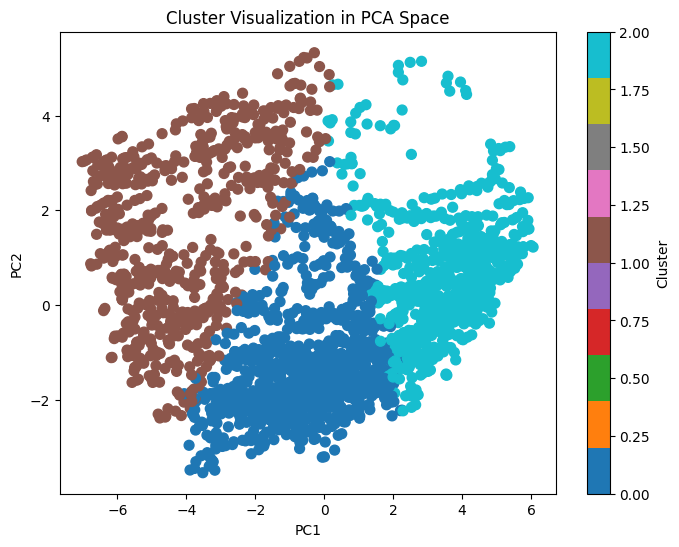

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, cmap='tab10', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cluster Visualization in PCA Space")
plt.colorbar(label="Cluster")
plt.show()


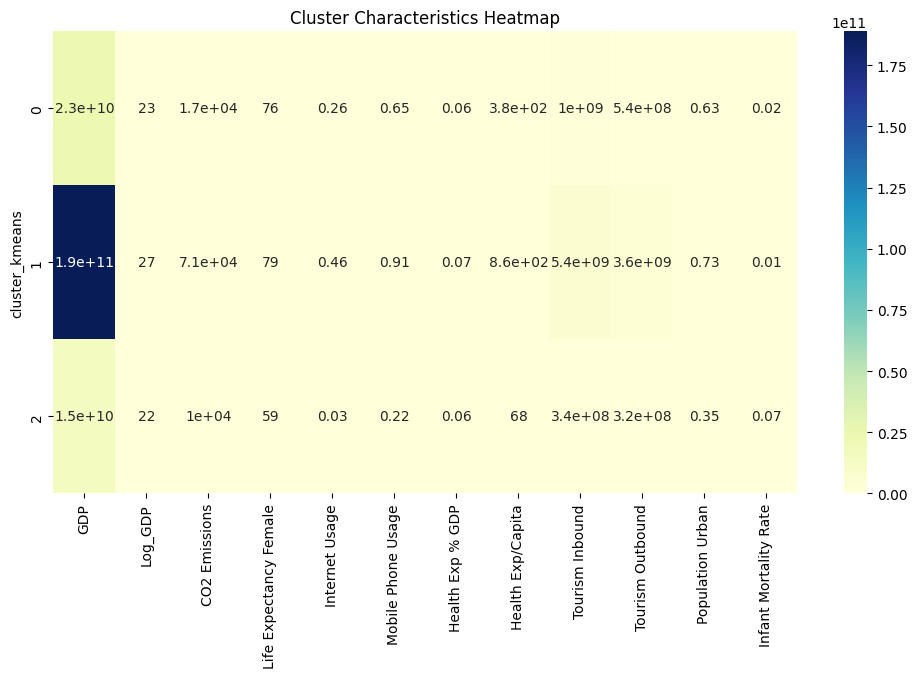

In [22]:
plt.figure(figsize=(12,6))
sns.heatmap(cluster_profile, annot=True, cmap="YlGnBu")
plt.title("Cluster Characteristics Heatmap")
plt.show()


In [26]:
km = KMeans(n_clusters=optimal_K, random_state=42)
km_pca = km.fit_predict(X)


In [27]:
km = KMeans(n_clusters=optimal_K, random_state=42)
km_labels = km.fit_predict(X)

print("KMeans cluster labels:", np.unique(km_labels))


KMeans cluster labels: [0 1 2]


In [28]:
# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=optimal_K)
agg_labels = agg.fit_predict(X)

print("Agglomerative cluster labels:", np.unique(agg_labels))

# Correct ARI calculation: compare label vectors
ari_agg = adjusted_rand_score(km_labels, agg_labels)
print("ARI: KMeans vs Agglomerative =", round(ari_agg, 3))

# Silhouette Score (Agglomerative)
sil_agg = silhouette_score(pca_data, agg_labels)
print("Silhouette Score (Agglomerative):", round(sil_agg, 3))


Agglomerative cluster labels: [0 1 2]
ARI: KMeans vs Agglomerative = 0.422
Silhouette Score (Agglomerative): 0.203


In [14]:
db = DBSCAN(eps=1.3, min_samples=5).fit_predict(pca_data)

df["cluster_dbscan"] = db
print("DBSCAN Labels:", np.unique(db))


DBSCAN Labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163]


In [15]:
plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=db_labels, cmap="tab20", s=40)
plt.title("DBSCAN Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.show()

NameError: name 'db_labels' is not defined

<Figure size 800x600 with 0 Axes>